# Problem Statement
The dataset consists of quarterly sales data of Coca-Cola from 1986 to 1996. Predict sales for the next two years by using time series forecasting and prepare a document for each model explaining how many dummy variables you have created and also include the RMSE value for each model.

# 1.1.Business objective
The business objective is to forecast Coca-Cola's quarterly sales for the next two years using historical sales data from 1986 to 1996. Accurate sales forecasts enable the company to:

Make informed decisions about production and inventory planning

Optimize distribution and logistics

Align marketing strategies with demand patterns

Avoid overstocking or understocking situations

Improve overall financial planning and budgeting

# 1.2.Constraints
Limited Data: The dataset covers only 10 years (40 quarters), which may not capture long-term changes in the market.

Seasonality & Trend: Sales likely follow seasonal patterns (e.g., more sales in summer). If not properly modeled, forecasts can be inaccurate.

Stationarity: Models like ARIMA need the data to be stable over time. Adjustments (e.g., differencing) may be needed but can reduce clarity.

Continuity Assumption: Forecasting assumes past trends will continue, which might not always be true due to market shifts.

Missing External Factors: The dataset only includes sales data, missing factors like marketing, competition, or economic conditions, which can influence sales.

In [121]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns
import statsmodels.formula.api as smf

# Load the Dataset

In [16]:
df=pd.read_excel("CocaCola_Sales_Rawdata.xlsx")

,Quarter,Sales
0,Q1_86,1734.83
1,Q2_86,2244.96
2,Q3_86,2533.80
3,Q4_86,2154.96
4,Q1_87,1547.82


# Data Exploration

In [19]:
df.head()

,Quarter,Sales
0,Q1_86,1734.83
1,Q2_86,2244.96
2,Q3_86,2533.80
3,Q4_86,2154.96
4,Q1_87,1547.82


In [21]:
df.tail()

,Quarter,Sales
37,Q2_95,4936.0
38,Q3_95,4895.0
39,Q4_95,4333.0
40,Q1_96,4194.0
41,Q2_96,5253.0


In [29]:
df.shape

(42, 2)

In [31]:
df.describe()

,Sales
count,42.000000
mean,2994.352857
std,977.931139
min,1547.820000
25%,2159.712500
50%,2782.375000
75%,3609.250000
max,5253.000000


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 804.0+ bytes


In [35]:
df.columns

Index(['Quarter', 'Sales'], dtype='object')

In [37]:
df.isnull().sum()

Quarter    0
Sales      0
dtype: int64

# Data Pre-processing

## 2.1 Data Cleaning, Feature Engineering

In [46]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 Quarter    0
Sales      0
dtype: int64


In [52]:
# Extract the year and quarter from the 'Quarter' column
df['Quarters'] = df['Quarter'].apply(lambda x: x[:2])  # Extract first two characters (Q1, Q2, etc.)
df.drop(['Quarter'], axis=1, inplace=True)  # Drop the original 'Quarter' column

In [56]:
# Create dummy variables for each quarter (Q1, Q2, Q3, Q4)
quarter_dummies = pd.get_dummies(df['Quarters'], prefix='Q')
df= pd.concat([df, quarter_dummies], axis=1)  # Add these dummy variables to the original dataframe


In [64]:
# Feature engineering: Create additional columns
df['t'] = np.arange(1, len(df) + 1)  # Create a time column 't'
df['t_squared'] = df['t']**2  # Create a squared time variable (quadratic trend)
df['log_Sales'] = np.log(df['Sales'])  # Log-transform sales data to stabilize variance

In [66]:
# Check the modified dataframe
print(df.head())

     Sales Quarters  Q_Q1  Q_Q2  Q_Q3  Q_Q4  t  t_squared  log_Sales
0  1734.83       Q1     1     0     0     0  1          1   7.458665
1  2244.96       Q2     0     1     0     0  2          4   7.716443
2  2533.80       Q3     0     0     1     0  3          9   7.837475
3  2154.96       Q4     0     0     0     1  4         16   7.675527
4  1547.82       Q1     1     0     0     0  5         25   7.344603


# 2.2 Outlier Treatment

In [71]:
# Calculate the IQR for the 'Sales' column to identify outliers
Q1 = df['Sales'].quantile(0.25)
Q3 = df['Sales'].quantile(0.75)
IQR = Q3 - Q1

In [73]:
# Define the acceptable range for the 'Sales' data
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [75]:
# Find and remove outliers based on the IQR
outliers = df[(df['Sales'] < lower_bound) | (df['Sales'] > upper_bound)]


In [77]:
# Remove outliers from the dataset
df_cleaned = df[(df['Sales'] >= lower_bound) & (df['Sales'] <= upper_bound)]


In [79]:
# Check the number of outliers removed
print(f"Outliers detected: {len(outliers)}")
print(f"Data points remaining after removing outliers: {len(df_cleaned)}")

Outliers detected: 0
Data points remaining after removing outliers: 42


# 3. Exploratory Data Analysis (EDA)

## 3.1 Summary Statistics

In [102]:
# Summary statistics for the dataset
print("=== Summary Statistics ===")
print(df_cleaned.describe())

# Checking for any missing values
print("\n=== Missing Values ===")
print(df_cleaned.isnull().sum())


=== Summary Statistics ===
             Sales       Q_Q1       Q_Q2       Q_Q3       Q_Q4          t  \
count    42.000000  42.000000  42.000000  42.000000  42.000000  42.000000   
mean   2994.352857   0.261905   0.261905   0.238095   0.238095  21.500000   
std     977.931139   0.445001   0.445001   0.431081   0.431081  12.267844   
min    1547.820000   0.000000   0.000000   0.000000   0.000000   1.000000   
25%    2159.712500   0.000000   0.000000   0.000000   0.000000  11.250000   
50%    2782.375000   0.000000   0.000000   0.000000   0.000000  21.500000   
75%    3609.250000   0.750000   0.750000   0.000000   0.000000  31.750000   
max    5253.000000   1.000000   1.000000   1.000000   1.000000  42.000000   

         t_squared  log_Sales  
count    42.000000  42.000000  
mean    609.166667   7.954004  
std     543.997396   0.320225  
min       1.000000   7.344603  
25%     126.750000   7.677723  
50%     462.500000   7.931053  
75%    1008.250000   8.191210  
max    1764.000000   8.

## 3.2 Identify the Trend

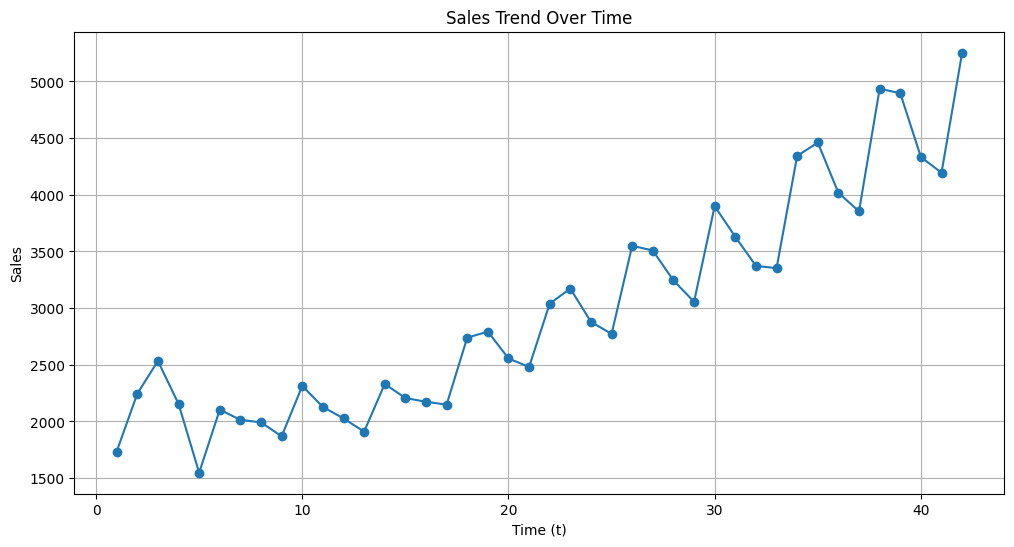

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

# Line plot to visualize sales trend over time
plt.figure(figsize=(12,6))
plt.plot(df_cleaned['t'],df_cleaned['Sales'], marker='o', linestyle='-')
plt.title('Sales Trend Over Time')
plt.xlabel('Time (t)')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


## 3.3 Identify Seasonality

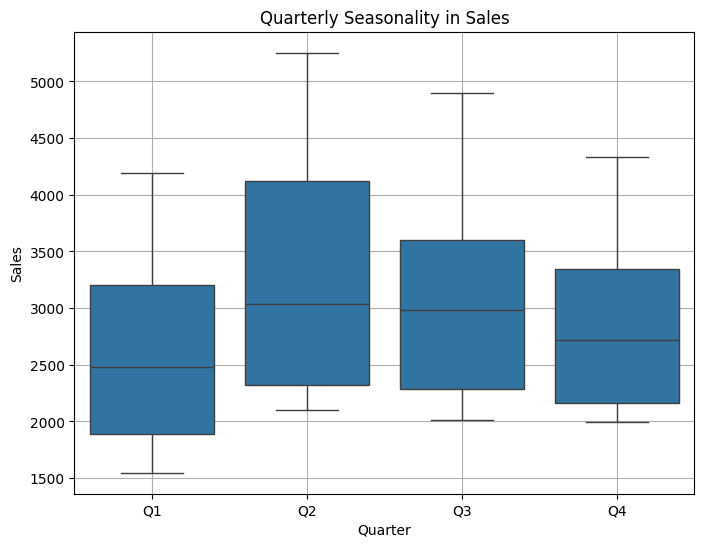

In [108]:
# Boxplot to visualize seasonality
plt.figure(figsize=(8,6))
sns.boxplot(x='Quarters', y='Sales', data=df_cleaned)
plt.title('Quarterly Seasonality in Sales')
plt.xlabel('Quarter')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


# 4. Model Building

## 4.1 Perform Forecasting on the Given Datasets
A. Moving Average Method

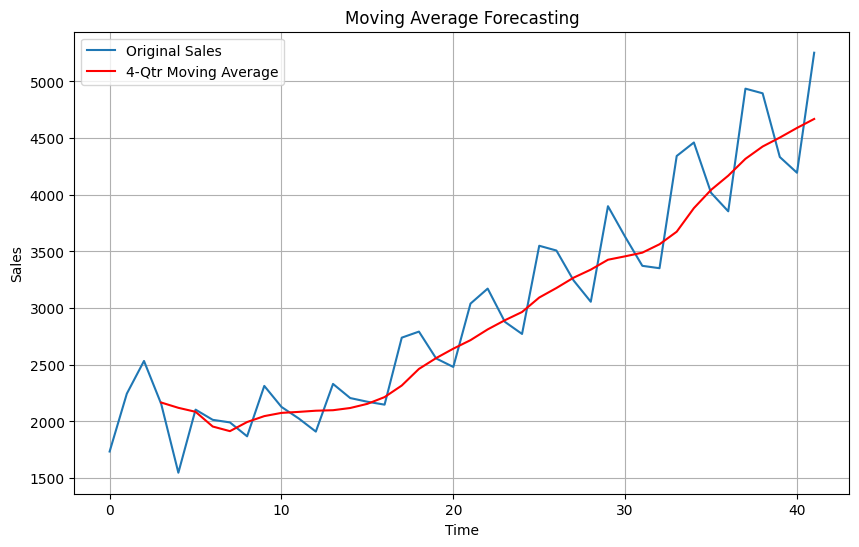

In [112]:
# 4-quarter Moving Average
df_cleaned['MA_4'] = df_cleaned['Sales'].rolling(window=4).mean()

# Plot moving average vs actual sales
plt.figure(figsize=(10,6))
plt.plot(df_cleaned['Sales'], label='Original Sales')
plt.plot(df_cleaned['MA_4'], color='red', label='4-Qtr Moving Average')
plt.title('Moving Average Forecasting')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


In [114]:
df_cleaned.head()

,Sales,Quarters,Q_Q1,Q_Q2,Q_Q3,Q_Q4,t,t_squared,log_Sales,MA_4
0,1734.83,Q1,1,0,0,0,1,1,7.458665,NaN
1,2244.96,Q2,0,1,0,0,2,4,7.716443,NaN
2,2533.80,Q3,0,0,1,0,3,9,7.837475,NaN
3,2154.96,Q4,0,0,0,1,4,16,7.675527,2167.1375
4,1547.82,Q1,1,0,0,0,5,25,7.344603,2120.3850


## B. Data-Driven Model

In [117]:
# Train-Test split (first 34 for train, last 8 for test)
Train = df_cleaned.head(34)
Test = df_cleaned.tail(8)

In [123]:
#1. Linear Trend Model
linear_model = smf.ols("Sales ~ t", data=Train).fit()
pred_linear = linear_model.predict(Test[["t"]])
rmse_linear = np.sqrt(np.mean((Test["Sales"] - pred_linear) ** 2))

In [125]:
#2. Exponential Trend Model
exp_model = smf.ols("log_Sales ~ t", data=Train).fit()
pred_exp = exp_model.predict(Test[["t"]])
rmse_exp = np.sqrt(np.mean((Test["Sales"] - np.exp(pred_exp)) ** 2))

In [127]:
#3. Quadratic Trend Model
quad_model = smf.ols("Sales ~ t + t_squared", data=Train).fit()
pred_quad = quad_model.predict(Test[["t", "t_squared"]])
rmse_quad = np.sqrt(np.mean((Test["Sales"] - pred_quad) ** 2))

In [136]:
#4. Additive Seasonality Model
add_sea_model = smf.ols("Sales ~ Q_Q1 + Q_Q2 + Q_Q3 + Q_Q4", data=Train).fit()
pred_add_sea = add_sea_model.predict(Test[["Q_Q1", "Q_Q2", "Q_Q3", "Q_Q4"]])
rmse_add_sea = np.sqrt(np.mean((Test["Sales"] - pred_add_sea) ** 2))

In [140]:
#5. Multiplicative Seasonality Model
mul_sea_model = smf.ols("log_Sales ~ Q_Q1 + Q_Q2 + Q_Q3 + Q_Q4", data=Train).fit()
pred_mul_sea = np.exp(mul_sea_model.predict(Test[["Q_Q1", "Q_Q2", "Q_Q3", "Q_Q4"]]))
rmse_mul_sea = np.sqrt(np.mean((Test["Sales"] - pred_mul_sea) ** 2))

In [142]:
#6. Additive Seasonality with Quadratic Trend 🏆 (Best Model)
add_sea_quad_model = smf.ols("Sales ~ t + t_squared + Q_Q1 + Q_Q2 + Q_Q3 + Q_Q4", data=Train).fit()
pred_add_sea_quad = add_sea_quad_model.predict(Test[["t", "t_squared", "Q_Q1", "Q_Q2", "Q_Q3", "Q_Q4"]])
rmse_add_sea_quad = np.sqrt(np.mean((Test["Sales"] - pred_add_sea_quad) ** 2))

In [144]:
#Multiplicative Seasonality with Linear Trend
mul_add_sea_model = smf.ols("log_Sales ~ t + Q_Q1 + Q_Q2 + Q_Q3 + Q_Q4", data=Train).fit()
pred_mul_add_sea = np.exp(mul_add_sea_model.predict(Test))
rmse_mul_add_sea = np.sqrt(np.mean((Test["Sales"] - pred_mul_add_sea) ** 2))

In [146]:
rmse_results = pd.DataFrame({
    "Model": [
        "Linear", "Exponential", "Quadratic",
        "Additive Seasonality", "Multiplicative Seasonality",
        "Additive Seasonality with Quadratic Trend",
        "Multiplicative Seasonality with Linear Trend"
    ],
    "RMSE": [
        rmse_linear, rmse_exp, rmse_quad,
        rmse_add_sea, rmse_mul_sea,
        rmse_add_sea_quad, rmse_mul_add_sea
    ]
})

print(rmse_results.sort_values(by="RMSE"))


                                          Model         RMSE
5     Additive Seasonality with Quadratic Trend   257.672615
6  Multiplicative Seasonality with Linear Trend   400.420138
2                                     Quadratic   437.745814
1                                   Exponential   564.984957
0                                        Linear   720.613618
3                          Additive Seasonality  1870.190509
4                    Multiplicative Seasonality  1940.804930


In [156]:
final_model = smf.ols('Sales ~ t + t_squared + Q_Q1 + Q_Q2 + Q_Q3 + Q_Q4', data=df_cleaned).fit()


In [160]:
# Prepare future time periods (43 to 50)
future = pd.DataFrame({
    't': np.arange(43, 51),
})
future['t_squared'] = future['t']**2

# Repeat the quarter dummies (Q1 to Q4 for 2 years)
quarters = ['Q_Q1', 'Q_Q2', 'Q_Q3', 'Q_Q4'] * 2
for q in ['Q_Q1', 'Q_Q2', 'Q_Q3', 'Q_Q4']:
    future[q] = [1 if quarter == q else 0 for quarter in quarters]

# Forecast sales
forecast = final_model.predict(future)
future['Forecasted_Sales'] = forecast
print(future[['t', 'Forecasted_Sales']])


    t  Forecasted_Sales
0  43       4765.489043
1  44       5554.974289
2  45       5623.934493
3  46       5449.169043
4  47       5387.913393
5  48       6191.463065
6  49       6274.487693
7  50       6113.786668


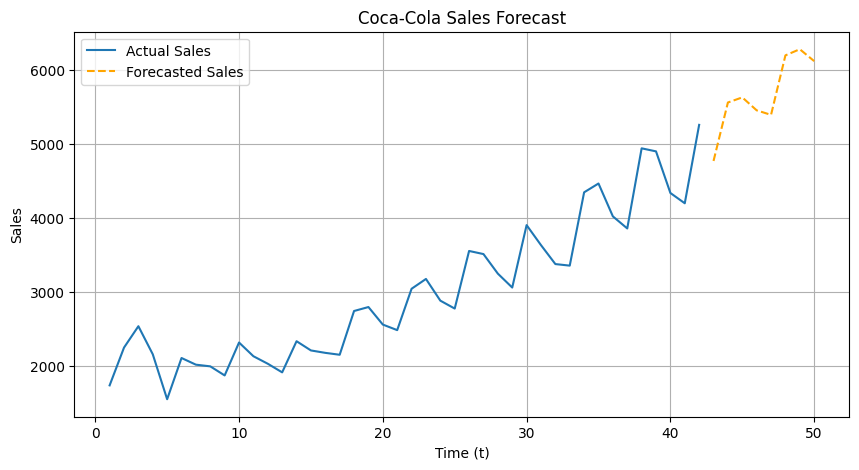

In [164]:
# Combine original and forecasted data for visualization
full_data = pd.concat([df_cleaned[['t', 'Sales']], future[['t', 'Forecasted_Sales']]], axis=0)

# Plot
plt.figure(figsize=(10,5))
plt.plot(full_data['t'], full_data['Sales'], label="Actual Sales")
plt.plot(full_data['t'], full_data['Forecasted_Sales'], label="Forecasted Sales", color='orange', linestyle='--')
plt.legend()
plt.title("Coca-Cola Sales Forecast")
plt.xlabel("Time (t)")
plt.ylabel("Sales")
plt.grid(True)
plt.show()


In [166]:
future.to_excel("CocaCola_Forecast_Next8Quarters.xlsx", index=False)

## 4.2 Exponential Smoothing Models

In [169]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing


In [171]:
# Simple Exponential Smoothing
ses_model = SimpleExpSmoothing(Train['Sales']).fit()
ses_pred = ses_model.forecast(len(Test))
rmse_ses = np.sqrt(np.mean((Test['Sales'] - ses_pred) ** 2))

In [173]:
# Holt’s Linear Trend Method
holt_model = Holt(Train['Sales']).fit()
holt_pred = holt_model.forecast(len(Test))
rmse_holt = np.sqrt(np.mean((Test['Sales'] - holt_pred) ** 2))

In [175]:
# Holt-Winters (Additive Seasonality + Trend)
hw_model = ExponentialSmoothing(Train['Sales'], trend='add', seasonal='add', seasonal_periods=4).fit()
hw_pred = hw_model.forecast(len(Test))
rmse_hw_add = np.sqrt(np.mean((Test['Sales'] - hw_pred) ** 2))

In [193]:
# Holt-Winters (Multiplicative Seasonality + Trend)
hw_model_mul = ExponentialSmoothing(Train['Sales'], trend='add', seasonal='mul', seasonal_periods=4).fit()
hw_pred_mul = hw_model_mul.forecast(len(Test))
rmse_hw_mul = np.sqrt(np.mean((Test['Sales'] - hw_pred_mul) ** 2))

In [195]:
print("RMSE - SES:", round(rmse_ses, 2))
print("RMSE - Holt:", round(rmse_holt, 2))
print("RMSE - Holt-Winters Additive:", round(rmse_hw_add, 2))
print("RMSE - Holt-Winters Multiplicative:", round(rmse_hw_mul, 2))

RMSE - SES: 786.84
RMSE - Holt: 456.05
RMSE - Holt-Winters Additive: 314.0
RMSE - Holt-Winters Multiplicative: 195.34


## 4.3 ARIMA (AutoRegressive Integrated Moving Average)

In [204]:
#A. Check Stationarity with ADF Test
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_cleaned['Sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: 1.309422237136884
p-value: 0.9966611741003198


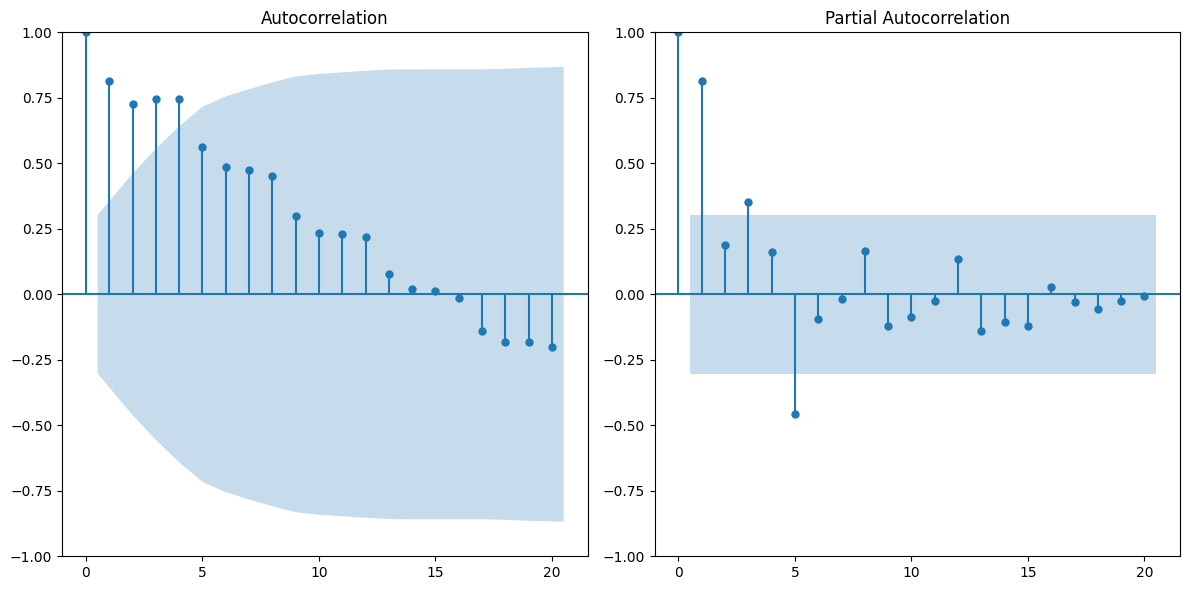

In [206]:
#B. Plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_acf(df_cleaned['Sales'], lags=20, ax=plt.gca())
plt.subplot(1,2,2)
plot_pacf(df_cleaned['Sales'], lags=20, ax=plt.gca())
plt.tight_layout()
plt.show()


In [210]:
#C. Fit ARIMA / Auto ARIMA
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# auto_arima to select the best parameters
auto_model = auto_arima(df_cleaned['Sales'], seasonal=True, m=4, trace=True,
                        error_action='ignore', suppress_warnings=True)

# Fitting the best ARIMA model
arima_model = ARIMA(df_cleaned['Sales'], order=auto_model.order)
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=8)
print("ARIMA Forecast:")
print(arima_forecast)

# Compare with actual (Test)
rmse_arima = np.sqrt(np.mean((Test['Sales'].values - arima_forecast.values) ** 2))
print("RMSE - ARIMA:", round(rmse_arima, 2))


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[4]             : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=488.647, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=491.401, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=491.202, Time=0.04 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=489.549, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=489.438, Time=0.03 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=491.335, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=490.586, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=490.538, Time=0.05 sec
 ARIMA(1,1,1)(0,1,0)[4]             : AIC=489.597, Time=0.05 sec
 ARIMA(0,1,0)(0,1,0)[4] intercept   : AIC=490.419, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[4]          
Total fit time: 0.541 seconds
ARIMA Forecast:
42    5253.0
43    5253.0
44    5253.0
45    5253.0
46    5253.0
47    5253.0
48    5253.0
49    5253.0
Name: predicted_mean, dtype: float64
RMSE - ARIMA